<a href="https://colab.research.google.com/github/aasharib/CV_Assignment_3/blob/main/CV_Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
DATASET_ZIP_PATH_DRIVE = '/content/drive/MyDrive/Semester1/CV/Assignment/3/intel-image-classification.zip'
DATASET_PATH_LOCAL = '/content/assgn3'
TRAIN_DATASET_PATH = DATASET_PATH_LOCAL + '/intel-image-classification/seg_train/seg_train'
VALIDATION_DATASET_PATH = DATASET_PATH_LOCAL + '/intel-image-classification/seg_test/seg_test'
TEST_DATASET_PATH = DATASET_PATH_LOCAL + '/intel-image-classification/seg_pred/seg_pred'
NUMBER_OF_EPOCHS = 75
INITIAL_LEARNING_RATE = 0.01
BATCH_SIZE = 256
MODEL_NAME = 'vgg16_trained_normal_vgg_3rdJan_9pm.h5'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!unzip -q $DATASET_ZIP_PATH_DRIVE -d $DATASET_PATH_LOCAL

replace /content/assgn3/intel-image-classification/seg_pred/seg_pred/buildings/10004.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: None


In [4]:
from sklearn.datasets import load_files
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Dropout
from keras.models import Sequential
from keras.optimizers import SGD
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
import itertools

In [5]:
trainData = load_files(TRAIN_DATASET_PATH ,load_content=False)
validationData = load_files(VALIDATION_DATASET_PATH , load_content=False)
testData = load_files(TEST_DATASET_PATH, load_content=False)

In [6]:
trainData

{'DESCR': None,
 'filenames': array(['/content/assgn3/intel-image-classification/seg_train/seg_train/glacier/6416.jpg',
        '/content/assgn3/intel-image-classification/seg_train/seg_train/buildings/5658.jpg',
        '/content/assgn3/intel-image-classification/seg_train/seg_train/street/7656.jpg',
        ...,
        '/content/assgn3/intel-image-classification/seg_train/seg_train/sea/13907.jpg',
        '/content/assgn3/intel-image-classification/seg_train/seg_train/sea/3467.jpg',
        '/content/assgn3/intel-image-classification/seg_train/seg_train/forest/14133.jpg'],
       dtype='<U82'),
 'target': array([2, 0, 5, ..., 4, 4, 1]),
 'target_names': ['buildings',
  'forest',
  'glacier',
  'mountain',
  'sea',
  'street']}

In [7]:
trainDataLabel = trainData.target
validationDataLabel = validationData.target
classLabels = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [8]:
def readAndPreprocessImage(imgFile):
    curImg = np.asarray(Image.open(imgFile).resize((150,150)))
    if curImg is not None:
        return curImg 

In [9]:
trainDataImgArr = np.array(list(map(readAndPreprocessImage, trainData.filenames)))

In [10]:
validationDataImgArr = np.array(list(map(readAndPreprocessImage, validationData.filenames)))

In [11]:
trainingDataImgX = trainDataImgArr
validationDataImgX = validationDataImgArr
trainingDataLabelY = trainDataLabel
validationDataLabelY = validationDataLabel

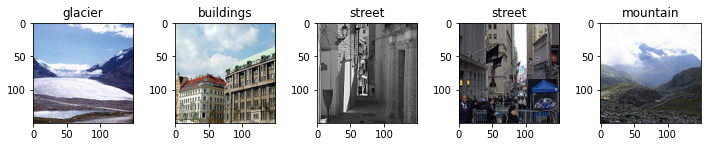

In [12]:
#displaying trainset image for preview
imgCountToShow = 5
fig, ax = plt.subplots(1,imgCountToShow,figsize=(10,10))
plt.tight_layout()
for imgIndex in range(0,imgCountToShow):
    ax[imgIndex].imshow(trainingDataImgX[imgIndex])
    ax[imgIndex].set_title(classLabels[trainingDataLabelY[imgIndex]])


In [13]:
mmodel = Sequential()
mmodel.add(Conv2D(64, kernel_size=3, padding='same', activation='relu',
                 input_shape=(150, 150, 3)))
mmodel.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))
mmodel.add(MaxPooling2D(pool_size=2, strides=2))
mmodel.add(Dropout(0.2))

mmodel.add(Conv2D(128, kernel_size=3, padding='same', activation='relu'))
mmodel.add(Conv2D(128, kernel_size=3, padding='same', activation='relu'))
mmodel.add(MaxPooling2D(pool_size=2, strides=2))
mmodel.add(Dropout(0.2))

mmodel.add(Conv2D(256, kernel_size=3, padding='same', activation='relu'))
mmodel.add(Conv2D(256, kernel_size=3, padding='same', activation='relu'))
mmodel.add(Conv2D(256, kernel_size=3, padding='same', activation='relu'))
mmodel.add(MaxPooling2D(pool_size=2, strides=2))
mmodel.add(Dropout(0.2))

mmodel.add(Conv2D(512, kernel_size=3, padding='same', activation='relu'))
mmodel.add(Conv2D(512, kernel_size=3, padding='same', activation='relu'))
mmodel.add(Conv2D(512, kernel_size=3, padding='same', activation='relu'))
mmodel.add(MaxPooling2D(pool_size=2, strides=2))
mmodel.add(Dropout(0.2))

mmodel.add(Conv2D(512, kernel_size=3, activation='relu'))
mmodel.add(Conv2D(512, kernel_size=3, activation='relu'))
mmodel.add(Conv2D(512, kernel_size=3, activation='relu'))
mmodel.add(MaxPooling2D(pool_size=2, strides=2))
mmodel.add(Dropout(0.2))

mmodel.add(Flatten())

mmodel.add(Dense(4096, activation='relu'))
mmodel.add(Dense(4096, activation='relu'))
mmodel.add(Dense(4096, activation='relu'))

# 6 classes to predict
mmodel.add(Dense(6, activation='softmax'))

In [14]:
mmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 75, 75, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 128)       0

In [15]:
sgd = SGD(lr=INITIAL_LEARNING_RATE, momentum=0.9, decay=INITIAL_LEARNING_RATE / NUMBER_OF_EPOCHS)
mmodel.compile(loss='categorical_crossentropy', 
              optimizer=sgd,
              metrics=['accuracy'])

In [16]:
trainingDataLabelOHE = to_categorical(trainingDataLabelY)
validationDataLabelOHE = to_categorical(validationDataLabelY)

In [17]:
imgDataAugmenter = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip = True,
		rotation_range=15,
		zoom_range=0.2,
		shear_range=0.15,
    width_shift_range=0.2,
		height_shift_range=0.2,
		fill_mode="nearest")

In [18]:
H = mmodel.fit(x=imgDataAugmenter.flow(trainingDataImgX, trainingDataLabelOHE, batch_size=BATCH_SIZE), epochs=NUMBER_OF_EPOCHS, validation_data=(validationDataImgX, validationDataLabelOHE))


Epoch 1/75
55/55 [==============================] - 93s 2s/step - loss: 1.8000 - accuracy: 0.1791 - val_loss: 1.6627 - val_accuracy: 0.3760
Epoch 2/75
55/55 [==============================] - 80s 1s/step - loss: 1.7380 - accuracy: 0.2654 - val_loss: 1.7633 - val_accuracy: 0.2933
Epoch 3/75
55/55 [==============================] - 80s 1s/step - loss: 1.7593 - accuracy: 0.2116 - val_loss: 1.7707 - val_accuracy: 0.1777
Epoch 4/75
55/55 [==============================] - 81s 1s/step - loss: 1.7393 - accuracy: 0.2580 - val_loss: 1.7814 - val_accuracy: 0.1617
Epoch 5/75
55/55 [==============================] - 80s 1s/step - loss: 1.6803 - accuracy: 0.3207 - val_loss: 1.5174 - val_accuracy: 0.4400
Epoch 6/75
55/55 [==============================] - 80s 1s/step - loss: 1.6515 - accuracy: 0.3211 - val_loss: 1.4095 - val_accuracy: 0.4080
Epoch 7/75
55/55 [==============================] - 80s 1s/step - loss: 1.5304 - accuracy: 0.3834 - val_loss: 1.3036 - val_accuracy: 0.4997
Epoch 8/75
55/55 [==

In [19]:
# save the model's trained weights
mmodel.save_weights(MODEL_NAME)

In [20]:
!cp /content/$MODEL_NAME /content/drive/MyDrive/Semester1/CV/Assignment/3

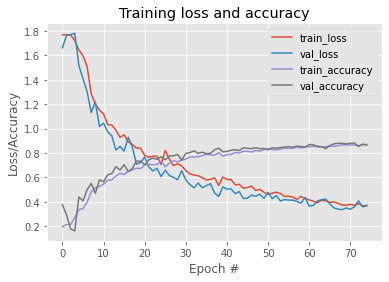

In [21]:

N = np.arange(0, NUMBER_OF_EPOCHS)
plt.style.use('ggplot')
plt.figure()
plt.plot(N, H.history['loss'], label='train_loss')
plt.plot(N, H.history['val_loss'], label='val_loss')
plt.plot(N, H.history['accuracy'], label='train_accuracy')
plt.plot(N, H.history['val_accuracy'], label='val_accuracy')
plt.title('Training loss and accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

In [22]:
testData
testDataImgArr = np.array(list(map(readAndPreprocessImage, testData.filenames)))
testDataLabel = testData.target
testDataLabelOHE = to_categorical(testDataLabel)

In [23]:
'''CONFUSION MATRIX'''
# Making prediction
predicatedTestDataY = mmodel.predict_classes(testDataImgArr)
actualTestDataY = np.argmax(testDataLabelOHE, axis=-1)

# Plotting the confusion matrix
confusionMatrix = confusion_matrix(actualTestDataY, predicatedTestDataY)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [24]:
print(confusionMatrix)

[[ 909   10    1    4    3  217]
 [   1 1153    2    1    2    7]
 [   1   12 1146  109   50   12]
 [   6    9  195 1018   65    4]
 [  16    7   89   78  925   13]
 [  47   18    2    4    8 1157]]


In [25]:
accuracyScore = accuracy_score(actualTestDataY, predicatedTestDataY)
print('Test Accuracy: {:.2%}'.format(accuracyScore))

Test Accuracy: 86.40%


In [26]:
#!cp /content/drive/MyDrive/Semester1/CV/Assignment/3/vgg16_trained_normal_vgg_2ndJan_2pm.h5 /content

In [27]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.2f}%; misclass={:0.2f}%'.format(accuracy*100, misclass*100))
    plt.show()

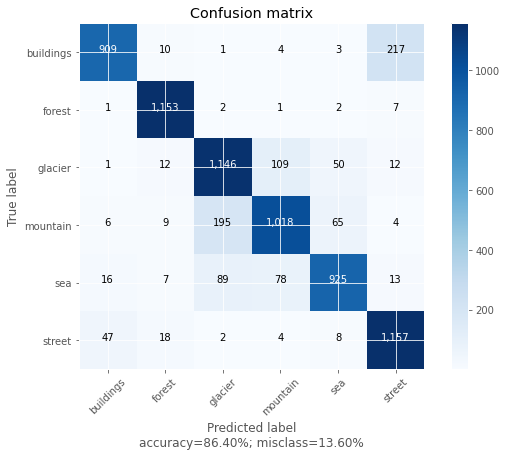

In [29]:
import seaborn as sns
plot_confusion_matrix(confusionMatrix, classLabels, normalize=False)
